In [9]:
import os
from binance.client import Client
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

## The Automatic Correlated Coin List (TACCL)

This script will allow you to build a list of correlated coins around a coin of your choice. You will need: 

1. A binance API Key
2. A chosen Bridge coin (Default USDT)
3. A chosen start coin (Default QUMT)

The script will do the rest. This is not a trading recommendation. Trading is risky, do not trade with money you cannot afford to lose. 

#### Basic strategy: 

This script will gather the data for all coin pairs available for your bridge coin. It will sequentially choose coins that maximise the sum of the correlations. This heuristic should pick a good list of co-related coins. 

## Usage Instructions

Run every line of the script. The final two boxes will display the recommended coin list and the heatmap of the rolling average for the last 24 hours.

In [10]:
api_key = PUT YOUR OWN KEY HERE
api_secret = PUT YOUR OWN KEY HERE
client = Client(api_key, api_secret)

In [11]:
def get_ticker_price(ticker_symbol: str, days:int ):
    """
    Gets ticker price of a specific coin
    """

    target_date = (datetime.now() -timedelta(days = days)).strftime("%d %b %Y %H:%M:%S")
    key = f"{ticker_symbol}"
    end_date = datetime.now() 
    end_date = end_date.strftime("%d %b %Y %H:%M:%S")
    
    coindata = pd.DataFrame(columns = [key])
    
    prices = []
    dates = []
    for result in client.get_historical_klines(
        ticker_symbol, "1m", target_date, end_date, limit=1000
        ):
        date = datetime.utcfromtimestamp(result[0] / 1000).strftime("%d %b %Y %H:%M:%S")
        price = float(result[1])
        dates.append(date)
        prices.append(price)

    coindata[key] = prices
    coindata['date'] = dates




    return(coindata.reindex(columns =['date',key]))

In [18]:
def get_price_data(tickers, window = 1, granularity = "1m"):
    '''
    Collects price data from the binance server.
    '''
    failures = []
    coindata = get_ticker_price(tickers[0],1)
    for tick in tickers[1:]:
        newdata = get_ticker_price(tick,1)
        if not newdata.empty:
            coindata = pd.merge(coindata, newdata)
        else:
            failures.append(tick)
    print('The following coins do not have historical data')
    print(failures)
    return(coindata)

In [13]:
def take_rolling_average(coindata):

    RA = pd.DataFrame()

    for column in coindata:
        if column != 'date':
            RA[column] = coindata[column].rolling(window=3).mean()
    return(RA)

In [14]:
def pick_coins(start_ticker , day_corr , week_corr, two_week_corr, n):
    '''
    Takes your starting coin, then sequentially picks the coin that jointly maximises
    the correlation for the whole coin list.
    
    INPUT:
    start_ticker : STR : The ticker for a coin you wish to include in your list
    day_corr     : PD.CORR : daily correlation data
    week_corr    : PD.CORR : Weekly correlation data
    two_week_corr: PD.CORR : bi-weekly correlation data
    n            : INTEGER : number of coins to include in your list.
    '''
    
    coinlist = [start_ticker]
    for i in range(n-1):    
        new_day_corr = day_corr[~day_corr.index.isin(coinlist)]
        new_week_corr = week_corr[~week_corr.index.isin(coinlist)]
        new_two_week_corr = two_week_corr[~two_week_corr.index.isin(coinlist)]
        corrsum = pd.DataFrame()
        for coin in coinlist:
            if corrsum.empty:
                corrsum = new_day_corr[coin] + new_week_corr[coin] + new_two_week_corr[coin]
            else:
                corrsum += new_day_corr[coin] + new_week_corr[coin] + new_two_week_corr[coin]
                
        ind = corrsum.argmax()
        coinlist.append(new_day_corr.index[ind])
    return(coinlist)

# Choose your Bridge coin and Starting coin here

In [15]:
bridge = 'USDT'
startcoin = 'QTUM'
size_of_list = 10

In [16]:
client = Client(api_key, api_secret)

# Download ALL the coinpairs from binance
exchange_info = client.get_exchange_info()

full_coin_list = [] 

# Only keep the pairs to our bridge coin
for s in exchange_info['symbols']:
    if s['symbol'].endswith(bridge):
        full_coin_list.append(s['symbol'][:-4])

# List of words to eliminate futures markets coins
forbidden_words = ['DOWN','UP','BULL','BEAR']
for forbidden in forbidden_words:
    full_coin_list = [word for word in full_coin_list if forbidden not in word]

#Alphabetical order because pretty :)
full_coin_list.sort()

In [19]:
# Collect the data for 3 different windows (1 day, 1 week, 2 weeks)
# with granularity (1 minute, 1 hour ,2 hours)

cointickers = [coin+ bridge for coin in full_coin_list]
day_data = get_price_data(cointickers, 1, "1m")
week_data = get_price_data(cointickers, 7, "1h")
two_week_data = get_price_data(cointickers, 14, "2h")

The following coins do not have historical data
['BCCUSDT', 'BCHABCUSDT', 'BCHSVUSDT', 'BKRWUSDT', 'DAIUSDT', 'ERDUSDT', 'HCUSDT', 'LENDUSDT', 'MCOUSDT', 'NPXSUSDT', 'STORMUSDT', 'STRATUSDT', 'USDSUSDT', 'USDSBUSDT', 'VENUSDT', 'XZCUSDT']
The following coins do not have historical data
['BCCUSDT', 'BCHABCUSDT', 'BCHSVUSDT', 'BKRWUSDT', 'DAIUSDT', 'ERDUSDT', 'HCUSDT', 'LENDUSDT', 'MCOUSDT', 'NPXSUSDT', 'STORMUSDT', 'STRATUSDT', 'USDSUSDT', 'USDSBUSDT', 'VENUSDT', 'XZCUSDT']
The following coins do not have historical data
['BCCUSDT', 'BCHABCUSDT', 'BCHSVUSDT', 'BKRWUSDT', 'DAIUSDT', 'ERDUSDT', 'HCUSDT', 'LENDUSDT', 'MCOUSDT', 'NPXSUSDT', 'STORMUSDT', 'STRATUSDT', 'USDSUSDT', 'USDSBUSDT', 'VENUSDT', 'XZCUSDT']


In [21]:
# Calculate the rolling average (RA3) for all the coins 

RA_day_data = take_rolling_average(day_data)
RA_week_data = take_rolling_average(week_data)
RA_2week_data = take_rolling_average(two_week_data)

In [22]:
# take the correlations of the rolling averages.

day_corr = RA_day_data.corr()
week_corr = RA_week_data.corr()
two_week_corr = RA_2week_data.corr()

coinlist = pick_coins(startcoin + bridge, day_corr , week_corr , two_week_corr , size_of_list )
coinlist = 

# TACCL result: 

This list is not a recommended trading list. Do not risk money if you are not sure what you are doing. 

In [27]:
coins = [coin.replace(bridge,'') for coin in coinlist]
print(coins)

['QTUM', 'VET', 'BTT', 'LSK', 'ZIL', 'ONT', 'ONG', 'NEO', 'ZRX', 'ARDR']


The rest of the code will plot the correlation matric for the rolling average of the selected coins.

In [28]:
# Grab coin prices from binance server 

### Set Period here ###
num_days = 1
###

#Create initial df with first coin then fill with all from list

coindata = get_ticker_price(coinlist[0],num_days)
for tick in coinlist[1:]:
    newdata = get_ticker_price(tick,num_days)
    coindata = pd.merge(coindata, newdata)

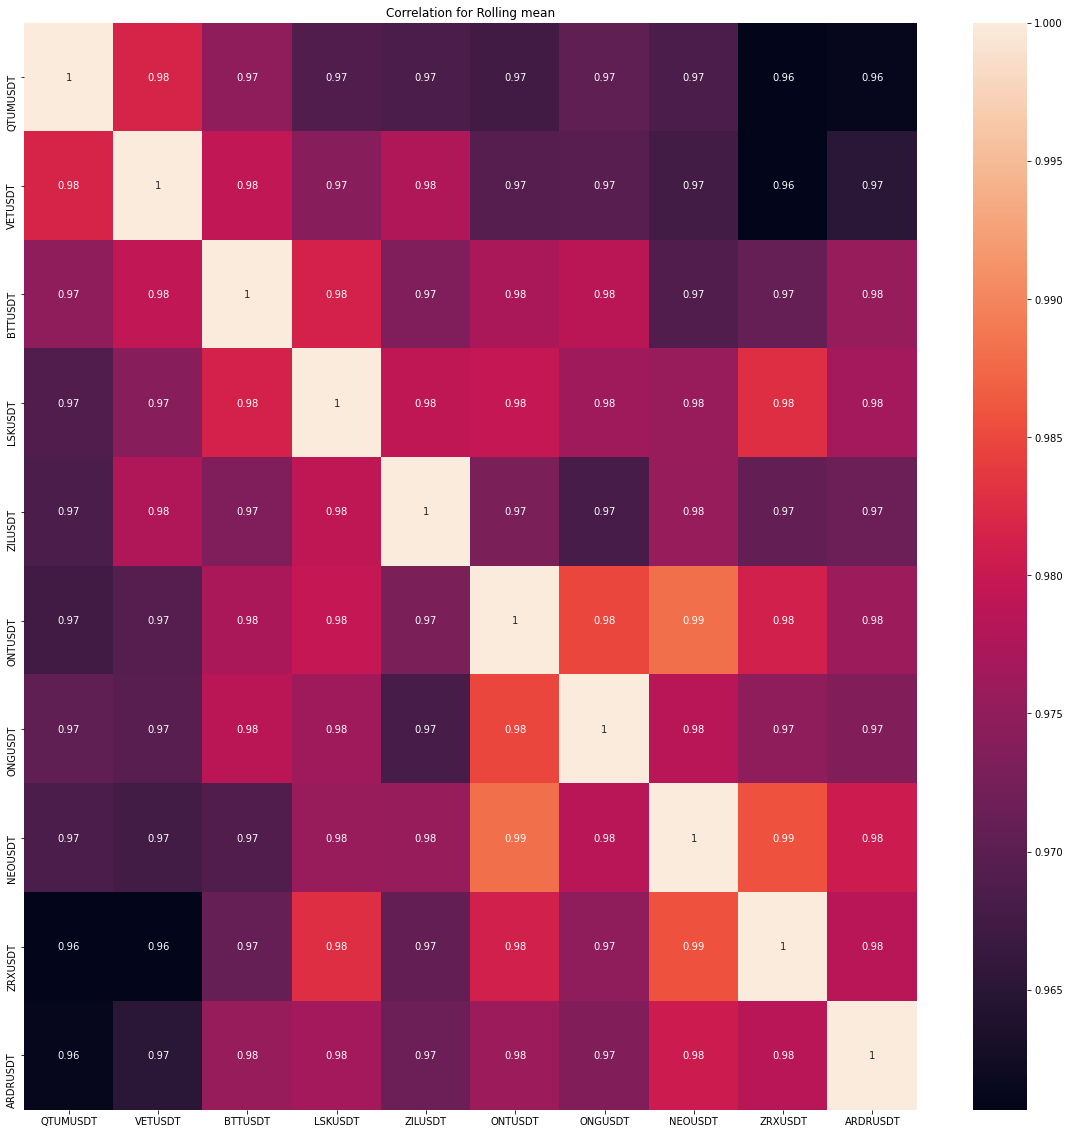

In [29]:
### Examine the trend of the rolling average

radf2 = pd.DataFrame()

for column in coindata:
    if column != 'date':
        radf2[column] = coindata[column].rolling(window=3).mean()

corrMatrix = radf2.corr()
fig = plt.figure(figsize=(20,20))
sn.heatmap(corrMatrix, annot=True)
plt.title('Correlation for Rolling mean')
plt.show()